In [58]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

Cíl: vytvořte model lineární regrese, který předpoví šanci na přijetí na vysokou školu (na základě dostupných dat).

In [59]:
data = pd.read_csv("adm_data.csv")   #...načtení dat pro práci
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [60]:
data.shape

(400, 9)

In [61]:
data.describe()     #abych si zkontrolovala co mám za data dle zadání vypsala jsem si různé charakteristiky

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [62]:
data.columns = data.columns.str.strip()    #v názvu posledního sloupečku jsou mezery za posledním slovem, abychom se jich zbavili strip()
# mezera byla i za LOR

In [63]:
data.rename(columns = {"GRE Score" : "GRE_Score", "TOEFL Score" : "TOEFL_Score", "University Rating":"University_Rating", "SOP": "sila_motivacniho_dopisu", "LOR": "sila_doporuceni", "CGPA" : "prumerna_zn_bakalar", "Chance of Admit" : "Chance_of_Admit"},inplace = True)
data             # pro lepší pochopení jsem si přejmenovala sloupce

,Serial No.,GRE_Score,TOEFL_Score,University_Rating,sila_motivacniho_dopisu,sila_doporuceni,prumerna_zn_bakalar,Research,Chance_of_Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


ÚKOLY

Normálnost dat pro TOEFL skóre

In [64]:
data["TOEFL_Score"].median()

107.0

In [65]:
data["TOEFL_Score"].mean()    # tuto hodnotu již známe z fce describe()

107.41

In [66]:
data["TOEFL_Score"].std()   # tuto informaci můžeme také vyčíst z fce describe()

6.069513777374126

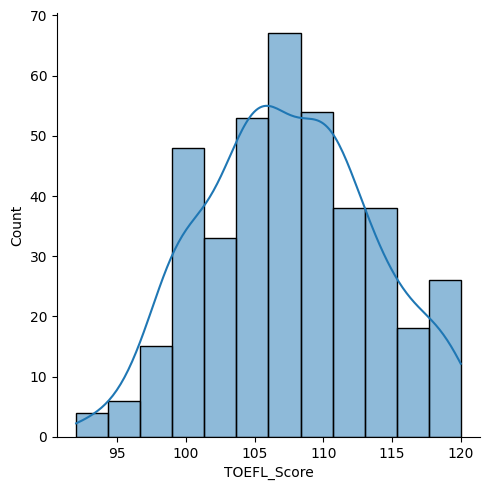

In [67]:
sns.displot (data=data, x = "TOEFL_Score", kde= True)   #histogram pro TOEFL s odhadovanou křivkou pravděpodobnostního rozdělení (density function)

Křivka pravděpodobnostního rozdělení naznačuje normální rozdělení. Proto otestujeme, zda se jedná o normální rozdělení dat či nikoli.

HO: Data mají normální rozdělení
H1: Data nemají normáloní rozdělení

In [68]:
stats.normaltest(data["TOEFL_Score"])

NormaltestResult(statistic=11.070212103496331, pvalue=0.003945790155853822)

protože nám vyšla p-value = 0.0039  <  0,05 (hladina významnosti) tedy H0 bychom měli zamítnout a dále pracovat s tím, že data nemají normální rozdělení pro TOEFL Score.

Testování hypotéz

Rozdělte data na studenty, kteří mají zkušenost s výzkumem a ty, co nemají

In [69]:
data_vyzkum_yes = data[data["Research"] == 1]
data_vyzkum_no = data[data["Research"] == 0]

In [70]:
data_vyzkum_no   #kontrola, že se to rozřadilo správně

,Serial No.,GRE_Score,TOEFL_Score,University_Rating,sila_motivacniho_dopisu,sila_doporuceni,prumerna_zn_bakalar,Research,Chance_of_Admit
4,5,314,103,2,2.0,3.0,8.21,0,0.65
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45
15,16,314,105,3,3.5,2.5,8.30,0,0.54
...,...,...,...,...,...,...,...,...,...
388,389,296,97,2,1.5,2.0,7.80,0,0.49
390,391,314,102,2,2.0,2.5,8.24,0,0.64
391,392,318,106,3,2.0,3.0,8.65,0,0.71
393,394,317,104,2,3.0,3.0,8.76,0,0.77


In [71]:
data_vyzkum_yes["GRE_Score"].mean()


322.85388127853884

In [72]:
data_vyzkum_no["GRE_Score"].mean()

309.49171270718233

otestujeme, zda existuje statisticky významný rozdíl v GRE Score mezi těmito 2 skupinami studentů...

Chceme porovnat průměry ve dvou datasetech
definujeme si hypotézy testu

H0: Studenti, kteří prošli výzkumem mají v průměru stejné GRE score, jako studenti, kteří výzkumem neprošli.
H1: Studenti, kteří prošli výzkumem mají v průměru jiné GRE score, jako studenti, kteří výzkumem neprošli.

In [73]:
stats.ttest_ind(data_vyzkum_yes["GRE_Score"], data_vyzkum_no["GRE_Score"])  #zvolila jsem t-test

TtestResult(statistic=14.218609390981028, pvalue=2.168740602699294e-37, df=398.0)

protože p-value vyšla << 0,05 H0 zamítáme a platí tedy že střední hodnota GRE score u studentů našich dvou skupin se liší. Existuje tak statisticky významný rozdíl pro GRE score u těchto dvou skupin. Což vyplývá i z porovnání samotných středních hodnot yes=323 <> no = 309.

Korelace

vypočítejte korelaci mezi TOEFL a GRE score

Abych si představila jak data TOEFL a GRE score na sobě zavisí, zobrazila jsem si je v bodovém grafu.

<Axes: xlabel='TOEFL_Score', ylabel='GRE_Score'>

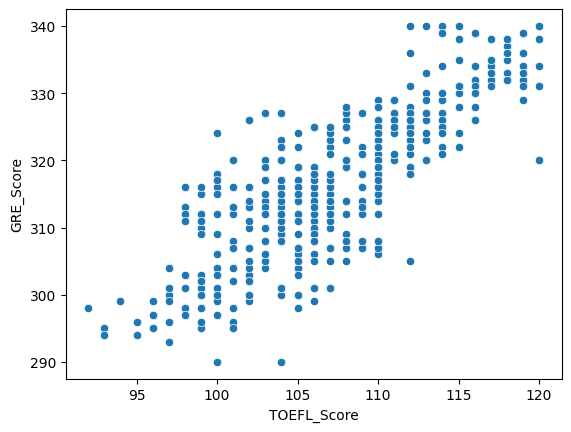

In [74]:
sns.scatterplot(data=data, x="TOEFL_Score", y="GRE_Score")   #z grafu je hezky videt stoupající lineární závislost a tedy jakási korelace dat

In [75]:
data.corr()  #korelační koeficient mezi TOEFLa GRE je 0.836, což znamená silnou pozitivní lineární závislost

,Serial No.,GRE_Score,TOEFL_Score,University_Rating,sila_motivacniho_dopisu,sila_doporuceni,prumerna_zn_bakalar,Research,Chance_of_Admit
Serial No.,1.000000,-0.097526,-0.147932,-0.169948,-0.166932,-0.088221,-0.045608,-0.063138,0.042336
GRE_Score,-0.097526,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL_Score,-0.147932,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
University_Rating,-0.169948,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
sila_motivacniho_dopisu,-0.166932,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
sila_doporuceni,-0.088221,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
prumerna_zn_bakalar,-0.045608,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,-0.063138,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance_of_Admit,0.042336,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


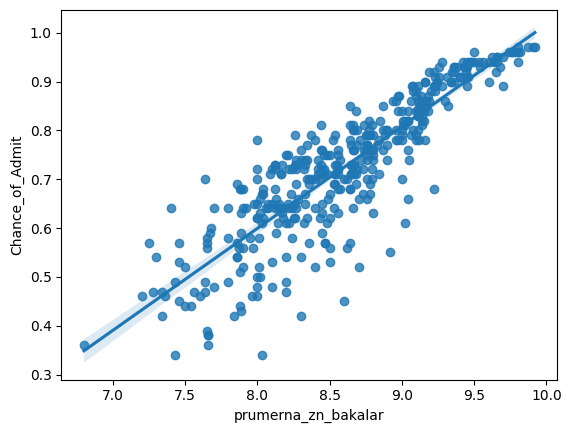

In [76]:
g = sns.regplot(data, x="prumerna_zn_bakalar", y="Chance_of_Admit")

In [77]:
formula = "Chance_of_Admit ~ prumerna_zn_bakalar"
mod = smf.ols(formula=formula, data=data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1279.
Date:                Mon, 06 May 2024   Prob (F-statistic):          2.34e-126
Time:                        20:42:12   Log-Likelihood:                 499.61
No. Observations:                 400   AIC:                            -995.2
Df Residuals:                     398   BIC:                            -987.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.0715      0.050    -21.285      0.000      -1.170      -0.973
prumerna_zn_bakalar     0.2088      0.006     35.759      0.000       0.197       0.220
==============================================================================
Omnibus:                       62.400   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.112
Skew:                          -0.926   Prob(JB):                     1.50e-23
Kurtosis:                       4.697   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vysvětlovaná proměnná

naší vysvětlovanou proměnnou bude šance na přijetí (Chance_of_Admit)

<Axes: ylabel='Chance_of_Admit'>

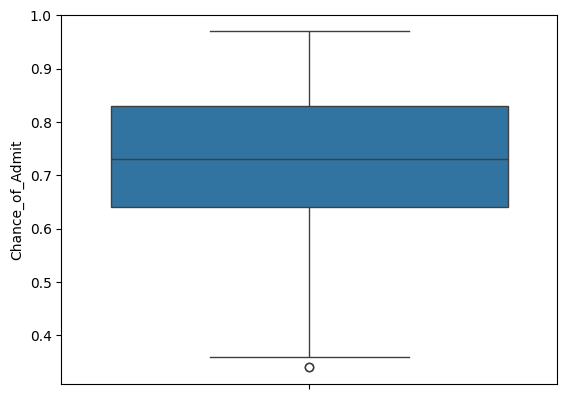

In [85]:
sns.boxplot(data, y="Chance_of_Admit")   #udelali jsem si boxplot, abychom viděli odlehlá pozorování

<Axes: xlabel='Chance_of_Admit'>

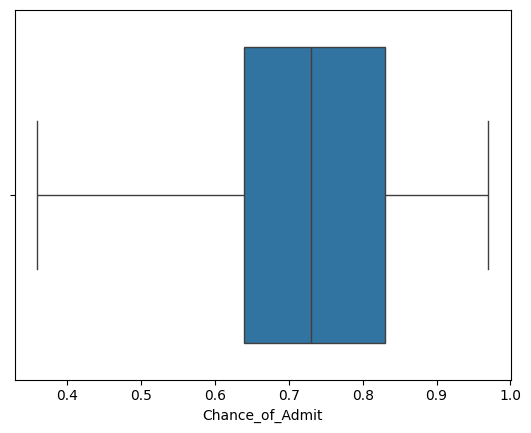

In [97]:
data_filtr = data[(data["Chance_of_Admit"]>= 0.35)]  # dle boxplotu vypadá, že odlehlá pozorování jsou ta pod 0.35
sns.boxplot(data_filtr, x="Chance_of_Admit")

In [98]:
data_filtr.shape    #kontrola, že se odfiltrovaly odlehlá pozorování

(398, 10)

In [96]:
data.shape

(400, 10)

Lineární regrese

In [79]:
data.columns

Index(['Serial No.', 'GRE_Score', 'TOEFL_Score', 'University_Rating',
       'sila_motivacniho_dopisu', 'sila_doporuceni', 'prumerna_zn_bakalar',
       'Research', 'Chance_of_Admit'],
      dtype='object')

sestavení formule pro regresni funkci na datech bez odlehlých pozorování a výpočet Cookovy vzdálenosti pro jednotlivé body

In [99]:
from statsmodels.stats.outliers_influence import OLSInfluence

formula = "Chance_of_Admit ~ GRE_Score + TOEFL_Score + University_Rating + sila_motivacniho_dopisu + sila_doporuceni + prumerna_zn_bakalar + Research"
mod = smf.ols(formula=formula, data=data_filtr)
results = mod.fit()
influence = OLSInfluence(results)
data['Cook Distance'] = influence.cooks_distance[0]
data.head()

,Serial No.,GRE_Score,TOEFL_Score,University_Rating,sila_motivacniho_dopisu,sila_doporuceni,prumerna_zn_bakalar,Research,Chance_of_Admit,Cook Distance
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.000383
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.000811
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.002403
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.001627
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.000098


In [101]:
data_filtr = data_filtr[data_filtr['Cook Distance'] < 1]
mod = smf.ols(formula=formula, data=data_filtr)
res = mod.fit()
res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     229.9
Date:                Mon, 06 May 2024   Prob (F-statistic):          3.78e-134
Time:                        21:38:17   Log-Likelihood:                 542.56
No. Observations:                 398   AIC:                            -1069.
Df Residuals:                     390   BIC:                            -1037.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.2107      0.123     -9.855      0.000      -1.452      -0.969
GRE_Score                   0.0017      0.001      2.843      0.005       0.001       0.003
TOEFL_Score                 0.0026      0.001      2.467      0.014       0.001       0.005
University_Rating           0.0054      0.005      1.147      0.252      -0.004       0.015
sila_motivacniho_dopisu    -0.0003      0.005     -0.063      0.950      -0.011       0.010
sila_doporuceni             0.0210      0.005      3.861      0.000       0.010       0.032
prumerna_zn_bakalar         0.1190      0.012      9.920      0.000       0.095       0.143
Research                    0.0237      0.008      3.040      0.003       0.008       0.039
==============================================================================
Omnibus:                       88.327   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.308
Skew:                          -1.164   Prob(JB):                     9.50e-41
Kurtosis:                       5.386   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

sestavení formule a Cookova vzdalenost pro puvodni data

In [102]:
formula = "Chance_of_Admit ~ GRE_Score + TOEFL_Score + University_Rating + sila_motivacniho_dopisu + sila_doporuceni + prumerna_zn_bakalar + Research"
mod = smf.ols(formula=formula, data=data_filtr)
results = mod.fit()
influence = OLSInfluence(results)
data['Cook Distance'] = influence.cooks_distance[0]
data.head()

,Serial No.,GRE_Score,TOEFL_Score,University_Rating,sila_motivacniho_dopisu,sila_doporuceni,prumerna_zn_bakalar,Research,Chance_of_Admit,Cook Distance
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.000383
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.000811
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.002403
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.001627
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.000098


spočetli jsem cookovu vzdálenost pro všechny body datasetu data. Cookova vzdálenost nám říká, jak jednotlivé body oblivnují regresní funkci, kdybychom je vynechali.

In [103]:
data = data[data['Cook Distance'] < 1]   # doporučené pravidlo je odstranit všechny hodnoty s Cookovou vzdáleností >1
mod = smf.ols(formula=formula, data=data)
res = mod.fit()
res.summary()                     # v summary vidíme, že University rating a sila motivacniho dopisu není statisticky významná, neboť P-value vyšlo >0.05

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     229.9
Date:                Mon, 06 May 2024   Prob (F-statistic):          3.78e-134
Time:                        21:38:56   Log-Likelihood:                 542.56
No. Observations:                 398   AIC:                            -1069.
Df Residuals:                     390   BIC:                            -1037.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.2107      0.123     -9.855      0.000      -1.452      -0.969
GRE_Score                   0.0017      0.001      2.843      0.005       0.001       0.003
TOEFL_Score                 0.0026      0.001      2.467      0.014       0.001       0.005
University_Rating           0.0054      0.005      1.147      0.252      -0.004       0.015
sila_motivacniho_dopisu    -0.0003      0.005     -0.063      0.950      -0.011       0.010
sila_doporuceni             0.0210      0.005      3.861      0.000       0.010       0.032
prumerna_zn_bakalar         0.1190      0.012      9.920      0.000       0.095       0.143
Research                    0.0237      0.008      3.040      0.003       0.008       0.039
==============================================================================
Omnibus:                       88.327   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.308
Skew:                          -1.164   Prob(JB):                     9.50e-41
Kurtosis:                       5.386   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regresni funkec bude vypadat takto i pro data původni i ta bez odlehlých pozorování:

y(Chance_of_Admit) = 0.0017*GRE_Score + 0.0026*TOEFL_Score + 0.0210*sila_doporuceni + 0.119*prumerna_zn_bakalare + 0.0237*Research - 1.2107

nejvíce ovlivňují šanci pro přijetí pruměrná známka za bakalařské studium a pak také doporučení studenta, protože u těchto proměnných vyšel největší koeficient Beta.

Koeficient determinace (R-squared) = 0.805, což nám říká, že náš model dokáže vysvětlit 80.5% vyriability šancí na přijetí studentů na univerzitu.
Model je statisticky významný, neboť p-value F-testu vyšla << 0.05.

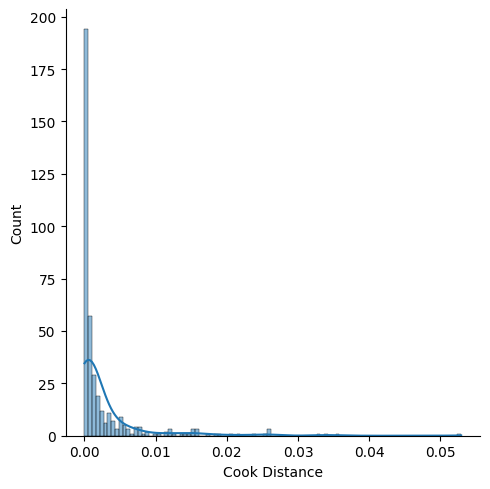

In [108]:
sns.displot (data["Cook Distance"], kde= True)

In [118]:
data["Cook Distance"].mean() # střední hodnota/průměr Cookovy vzdálenosti v datasetu Data je 0.0027, což se dá považovat za nulu

0.0026808398801684533

In [113]:
Data_omezena= data[(data["Cook Distance"]>=0) & (data["Cook Distance"] <=0.01)]

In [115]:
Data_omezena["Cook Distance"].mean()    # střední hodnota/průměr Cookovy vzdálenosti v datasetu Data je 0.0013, což se dá považovat za nulu

0.0012768863762377487

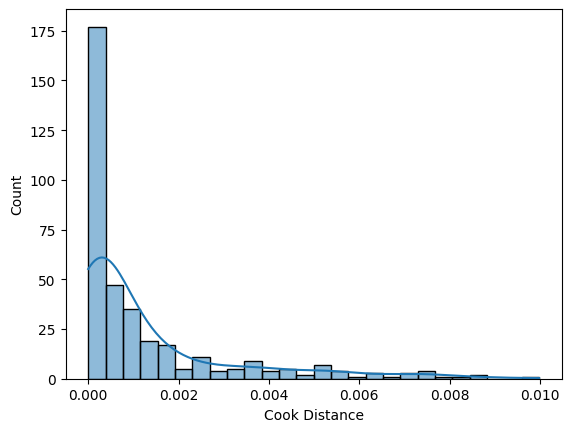

In [117]:
ax = sns.histplot (Data_omezena["Cook Distance"], kde= True)
